In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision

**Signal to Visibility Graph Creation Algorithms**

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import torch
import h5py
import os

In [ ]:
def normalise(d):
    m=sum(d)/len(d)
    for i in range(len(d)):
        d[i]=(d[i]-m)
    Max=d[0]
    for i in d:
        if abs(i)>Max:
            Max=abs(i)
    for i in range(len(d)):
        d[i]=d[i]/Max

    return d

In [ ]:

def HVG(TS):

    G=nx.Graph()
    G.add_node(0)
    for i in range(len(TS)-1):
        G.add_node(i+1)
        G.add_edge(i,i+1)
    for i in range(len(TS)-2):
        M=TS[i+1]
        for j in range(i+2,len(TS)):
            if M>TS[i]:
                break
            if TS[i]>M and TS[j]>M:
                G.add_edge(i,j)
                M=TS[j]
    return G

In [ ]:

def Alpha(signal,dist):
    idx=[i for i in range(len(signal))]
    cross_idx=[0]
    for i in range(len(signal)-1):
        l=cross_idx[-1]
        if signal[i]*signal[i+1]<0:
            if signal[i]>signal[i+1] and i-l>dist:
                cross_idx.append(i)
            elif signal[i+1]>signal[i] and i+1-l>dist:
                cross_idx.append(i+1)
    last_idx_of_signal=len(signal)-1
    if last_idx_of_signal not in cross_idx:
        cross_idx.append(last_idx_of_signal)
    alphas=[]
    for i in range(len(cross_idx)-1):
        I=[j for j in range(cross_idx[i],cross_idx[i+1]+1)]
        M1=abs(signal[I[0]])
        M=signal[I[0]]
        for k in I:
            if abs(signal[k])>M1:
                M1=abs(signal[k])
                M=signal[k]
        alpha=(abs(signal[cross_idx[i]]-M)+abs(signal[cross_idx[i+1]]-M))/(cross_idx[i+1]-cross_idx[i])
        for _ in range(cross_idx[i+1]-cross_idx[i]):
            alphas.append(round(alpha,3))
    return alphas


def Average_alpha(signal,A,B):
    d1=Alpha(signal,A)
    d2=Alpha(signal,B)
    d=[]
    dif=[]
    for i in range(len(signal)-1):
        d.append((d1[i]+d2[i])/2)
    return d

In [ ]:
def NERHVG(TS):
    TS=normalise(TS)
    Avg_alpha=Average_alpha(TS,10,25)
    G=nx.Graph()
    G.add_node(0)
    for i in range(len(TS)-1):
        G.add_node(i+1)
        if abs(TS[i]-TS[i+1])<Avg_alpha[i]:
            G.add_edge(i,i+1)
    for i in range(len(TS)-2):
        M=TS[i+1]
        for j in range(i+2,len(TS)):
            if M>=TS[i]:
                break
            if TS[i]>M and TS[j]>M:
                G.add_edge(i,j)
                M=TS[j]

    return G

In [ ]:
def nodeFeatures(G): #Node features: [degree of node, local CC of node]
    features = {} #dictionary for key value pairs for (node v: [degree of v, local_clustering_coeff_of_v] )

    for n in G.nodes():
        neighbors = [x for x in G[n]]
        num_neighbors = len(neighbors) #or degree

        if num_neighbors <= 1:
           features[n] = [num_neighbors, 0.0]
        else:
            num_connected_pairs = 0
            for i in range(num_neighbors):
                for j in range(i + 1, num_neighbors):
                    if G.has_edge(neighbors[i], neighbors[j]):
                        num_connected_pairs += 1
            CC=2 * num_connected_pairs / (num_neighbors * (num_neighbors - 1))
            features[n] = [num_neighbors, round(CC,2)]

    return torch.tensor(list(features.values()))

# for a 3X3 graph the output of this function is like,
# Nodefeatures:
#   tensor([[1.0000, 0.0000],
#         [3.0000, 0.3330],
#         [2.0000, 1.0000],
#         [2.0000, 1.0000]])


**Training Graph Dataset Creation**

In [ ]:

D=pd.read_csv(r"/content/drive/MyDrive/PPG_Dataset/vii_Normalized_Nonoverlapped_clean_data_3seconds_from3174samples.csv")



In [ ]:
#sampling some integers on the length of the PPG signal file to get all kind of signal from few number of signals
import random
import pickle
Range = list(range(10001, len(D)))

sample_idx= random.sample(Range, 15000)
sample_idx.sort()
#print("Sampled integers:", sample_idx)
with open('/content/drive/MyDrive/PPG_Dataset/Data_Sampling_index/sample_idx7', 'wb') as f: #Saving Dataset
    pickle.dump(sample_idx, f)


In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader

Dataset=[]
for i in sample_idx:
  g=HVG(normalise(D.iloc[i,:]))
  A=nx.adjacency_matrix(g)
  edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
  edge_index= torch.tensor(edges, dtype=torch.long)
  edge_index = edge_index.contiguous()
  label=torch.tensor([0], dtype=torch.float32)
  x1=nodeFeatures(g)
  Dataset.append(Data(x=x1, edge_index=edge_index, y=label))

with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset7.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset, f)


<ipython-input-17-5b07ba5e8fff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index= torch.tensor(edges, dtype=torch.long)


In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader

Dataset1=[]
for i in sample_idx:
  g=NERHVG(normalise(D.iloc[i,:]))
  A=nx.adjacency_matrix(g)
  edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
  edge_index= torch.tensor(edges, dtype=torch.long)
  edge_index = edge_index.contiguous()
  label=torch.tensor([0], dtype=torch.float32)
  x1=nodeFeatures(g)
  Dataset1.append(Data(x=x1, edge_index=edge_index, y=label))

with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset7.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset1, f)


<ipython-input-18-c6b31d93cea9>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index= torch.tensor(edges, dtype=torch.long)


In [ ]:
import random
import pickle
#HVG Training Data
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset2_ovrlp.pkl', 'rb') as f:
    Dataset2=pickle.load(f)
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset3.pkl', 'rb') as f:
    Dataset3=pickle.load(f)
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset7.pkl', 'rb') as f:
    Dataset7=pickle.load(f)
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset1.pkl', 'rb') as f:
    Dataset1=pickle.load(f)
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset8.pkl', 'rb') as f:
    Dataset8=pickle.load(f)
with open('/content/drive/MyDrive/HVG_Training/HVG_Dataset9.pkl', 'rb') as f:
    Dataset9=pickle.load(f)
Dataset_HVG=Dataset2+Dataset3+Dataset7+Dataset1+Dataset8+Dataset9
random.shuffle(Dataset_HVG)
with open('/content/drive/MyDrive/Training_Graph/Training_HVG_1_2_3_7_8_9.pkl', 'wb') as f:
    pickle.dump(Dataset_HVG, f)

len(Dataset_HVG)

In [ ]:
#NERHVG Training Data
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset1.pkl', 'rb') as f:
    Dataset1=pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset8.pkl', 'rb') as f:
    Dataset8=pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset9.pkl', 'rb') as f:
    Dataset9=pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset2_ovrlp.pkl', 'rb') as f: #Saving Dataset
    Dataset2=pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset3.pkl', 'rb') as f: #Saving Dataset
    Dataset3=pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Training/NERHVG_Dataset7.pkl', 'rb') as f: #Saving Dataset
    Dataset7=pickle.load(f)
Dataset_NERHVG=Dataset2+Dataset3+Dataset7+Dataset1+Dataset8+Dataset9
random.shuffle(Dataset_NERHVG)
with open('/content/drive/MyDrive/Training_Graph/Training_NERHVG_1_2_3_7_8_9.pkl', 'wb') as f:
    pickle.dump(Dataset_NERHVG, f)
len(Dataset_NERHVG)

**Testing Graph Data Creation**

In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader
import pandas as pd
D1=pd.read_csv(r"/content/drive/MyDrive/Test data/Vital/mean_norm_movavgFilt5pt_clean_vitaldb.csv") #signal segment loading
d1=list(D1.iloc[:,0])
l1=len(d1)//375
Dataset1=[]
for i in range(l1):
  g=HVG(normalise(d1[i*375:(i+1)*375]))
  A=nx.adjacency_matrix(g)
  edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
  edge_index= torch.tensor(edges, dtype=torch.long)
  edge_index = edge_index.contiguous()
  label=torch.tensor([0], dtype=torch.float32)
  x1=nodeFeatures(g)
  Dataset1.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format

D2=pd.read_csv(r"/content/drive/MyDrive/Test data/Vital/noisy_vital_awgn15_meanNorm.csv") #signal segment loading
d2=list(D2.iloc[:,0])
l2=len(d2)//375
Dataset2=[]
for i in range(l2):
  g=HVG(normalise(d2[i*375:(i+1)*375]))
  A=nx.adjacency_matrix(g)
  edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
  edge_index = torch.tensor(edges, dtype=torch.long)
  edge_index = edge_index.contiguous()
  label=torch.tensor([1], dtype=torch.float32)
  x1=nodeFeatures(g)
  Dataset2.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format

Dataset=Dataset1+Dataset2
print(len(Dataset))
random.shuffle(Dataset)
with open('/content/drive/MyDrive/Test data/Vital/HVG_Vital.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset, f)

<ipython-input-26-dfba73373654>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index= torch.tensor(edges, dtype=torch.long)
<ipython-input-26-dfba73373654>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edges, dtype=torch.long)


8796


In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader
import pandas as pd
import os
Dataset_main1=[]
directory_path=r"/content/drive/MyDrive/Test data/Queensland/Queens_test_clean"
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        D1=pd.read_csv(file_path)
        d1=list(D1.iloc[:,0])
        l1=len(d1)//375
        Dataset1=[]
        for i in range(l1):
          g=NERHVG(normalise(d1[i*375:(i+1)*375]))
          A=nx.adjacency_matrix(g)
          edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
          edge_index= torch.tensor(edges, dtype=torch.long)
          edge_index = edge_index.contiguous()
          label=torch.tensor([0], dtype=torch.float32)
          x1=nodeFeatures(g)
          Dataset1.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format
        Dataset_main1=Dataset_main1+Dataset1

In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader
import pandas as pd
import os
Dataset_main2=[]
directory_path=r"/content/drive/MyDrive/Test data/Queensland/Queens_test_noisy"
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        D2=pd.read_csv(file_path)
        d2=list(D2.iloc[:,0])
        l2=len(d2)//375
        Dataset2=[]
        for i in range(l2):
          g=NERHVG(normalise(d2[i*375:(i+1)*375]))
          A=nx.adjacency_matrix(g)
          edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
          edge_index= torch.tensor(edges, dtype=torch.long)
          edge_index = edge_index.contiguous()
          label=torch.tensor([1], dtype=torch.float32)
          x1=nodeFeatures(g)
          Dataset2.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format
        Dataset_main2=Dataset_main2+Dataset2

In [ ]:
import random
import pickle
Dataset=Dataset_main1+Dataset_main2
print(len(Dataset))
with open('/content/drive/MyDrive/Test data/Queensland/NERHVG_Queens.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset, f)

6321


In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader
import pandas as pd
import os
Dataset_main1=[]
directory_path=r"/content/drive/MyDrive/Test data/PTT/PTT_clean"
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        D1=pd.read_csv(file_path)
        d1=list(D1.iloc[:,0])
        l1=len(d1)//375
        Dataset1=[]
        for i in range(l1):
          g=HVG(normalise(d1[i*375:(i+1)*375]))
          A=nx.adjacency_matrix(g)
          edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
          edge_index= torch.tensor(edges, dtype=torch.long)
          edge_index = edge_index.contiguous()
          label=torch.tensor([0], dtype=torch.float32)
          x1=nodeFeatures(g)
          Dataset1.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format
        Dataset_main1=Dataset_main1+Dataset1

In [ ]:
import pickle
import torch
import random
from torch_geometric.data import Data, DataLoader
import pandas as pd
import os
Dataset_main2=[]
directory_path=r"/content/drive/MyDrive/Test data/PTT/PTT_noisy"
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        D2=pd.read_csv(file_path)
        d2=list(D2.iloc[:,0])
        l2=len(d2)//375
        Dataset2=[]
        for i in range(l2):
          g=HVG(normalise(d2[i*375:(i+1)*375]))
          A=nx.adjacency_matrix(g)
          edges = torch.nonzero(torch.tensor(A.toarray()), as_tuple=False).t()
          edge_index= torch.tensor(edges, dtype=torch.long)
          edge_index = edge_index.contiguous()
          label=torch.tensor([1], dtype=torch.float32)
          x1=nodeFeatures(g)
          Dataset2.append(Data(x=x1, edge_index=edge_index, y=label)) #Data format
        Dataset_main2=Dataset_main2+Dataset2

In [ ]:
import random
import pickle
Dataset=Dataset_main1+Dataset_main2
print(len(Dataset))
with open('/content/drive/MyDrive/Test data/PTT/HVG_PTT.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset, f)

6089


In [ ]:
len(Dataset)

6089

**Tuning Graph Data Creation**

In [ ]:
D=pd.read_csv(r"/content/drive/MyDrive/PPG_Dataset/vi_Normalized_Noise_data_3seconds_wrist_cup.csv")

In [ ]:
len(D)

5041

In [ ]:
import pickle
import torch
from torch_geometric.data import Data, DataLoader
import pandas as pd
D=pd.read_csv(r"/content/drive/MyDrive/PPG_Dataset/ix_Normalized_xrand_only_from_Ma_acc_rand_wrist_cup.csv") #signal segment loading
Dataset9=[]
for i in range(15000):
  g_nerhvg=NERHVG(normalise(D.iloc[i,:]))
  A_NERHVG=nx.adjacency_matrix(g_nerhvg)
  edges_NERHVG = torch.nonzero(torch.tensor(A_NERHVG.toarray()), as_tuple=False).t()
  edge_index_NERHVG = torch.tensor(edges_NERHVG, dtype=torch.long)
  edge_index_NERHVG = edge_index_NERHVG.contiguous()
  label=torch.tensor([1], dtype=torch.float32)
  x1=nodeFeatures(g_nerhvg)
  Dataset9.append(Data(x=x1, edge_index=edge_index_NERHVG, y=label)) #Data format
with open('/content/drive/MyDrive/NERHVG_Pickle/graph9_0_15000.pkl', 'wb') as f: #Saving Dataset
    pickle.dump(Dataset9, f)

<ipython-input-14-ebdf8597a5cb>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_NERHVG = torch.tensor(edges_NERHVG, dtype=torch.long)


In [ ]:
import random
import os
import torch
from torch_geometric.data import Data, DataLoader
import pickle

#Dataset.append(Data(x=x1, edge_index=edge_index1, y=y1))
with open('/content/drive/MyDrive/NERHVG_Pickle/graph2.pkl', 'rb') as f:
    dataset2 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph2_ovrlp.pkl', 'rb') as f:
    dataset2_ovrlp = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph3_0_30000.pkl', 'rb') as f:
    dataset3 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph7.pkl', 'rb') as f:
    dataset7 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph8_0_10000.pkl', 'rb') as f:
    dataset8 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph9_0_15000.pkl', 'rb') as f:
    dataset9 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph10_0_45320.pkl', 'rb') as f:
    dataset10 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph4.pkl', 'rb') as f:
    dataset4 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph5.pkl', 'rb') as f:
    dataset5 = pickle.load(f)
with open('/content/drive/MyDrive/NERHVG_Pickle/graph6.pkl', 'rb') as f:
    dataset6 = pickle.load(f)
Dataset_clean=dataset2+dataset2_ovrlp[0:9223]+dataset3[0:10000]+dataset7[0:10000]
random.shuffle(Dataset_clean)
Dataset_noisy=dataset4+dataset5+dataset6+dataset8[0:5000]+dataset9[0:8743]+dataset10[0:5000]
random.shuffle(Dataset_noisy)
Dataset=Dataset_clean+Dataset_noisy
random.shuffle(Dataset)


In [ ]:
len(Dataset)

60000

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(Dataset, test_size=0.2, random_state=42)

with open('/content/drive/MyDrive/NERHVG_Pickle/Training_NERHVG.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('/content/drive/MyDrive/NERHVG_Pickle/Val_NERHVG.pkl', 'wb') as f:
    pickle.dump(val_data, f)

# **GCN Classifier Model for HVG & NERHVG Graphs**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import torch.optim as optim

class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, 4)
        self.conv3 = GCNConv(4,2)
        self.conv4 = GCNConv(2,1)
        #self.conv5 = GCNConv(2,1)
        self.lin = nn.Linear(1, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = F.leaky_relu(self.conv4(x, edge_index))
        #x = F.leaky_relu(self.conv5(x, edge_index))
        batch_aggregated_embeddings = []
        for batch_id in batch.unique():
            graph_indices = (batch == batch_id).nonzero().squeeze(1)
            graph_embedding = torch.mean(x[graph_indices], dim=0)
            batch_aggregated_embeddings.append(graph_embedding)

        return torch.sigmoid(self.lin(torch.stack(batch_aggregated_embeddings)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import torch.optim as optim

class GCNClassifier2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNClassifier2, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, 8)
        self.conv3 = GCNConv(8,4)
        self.conv4 = GCNConv(4,2)
        self.conv5 = GCNConv(2,1)
        self.lin = nn.Linear(1, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = F.leaky_relu(self.conv4(x, edge_index))
        x = F.leaky_relu(self.conv5(x, edge_index))
        batch_aggregated_embeddings = []
        for batch_id in batch.unique():
            graph_indices = (batch == batch_id).nonzero().squeeze(1)
            graph_embedding = torch.mean(x[graph_indices], dim=0)
            batch_aggregated_embeddings.append(graph_embedding)

        return torch.sigmoid(self.lin(torch.stack(batch_aggregated_embeddings)))

# **Model Hyperparameter Tuning**

In [ ]:
#HVG Training Validation Data
import pickle
with open('/content/drive/MyDrive/Tuning_graph/Train_data.pkl', 'rb') as f:
    train_data=pickle.load(f)
with open('/content/drive/MyDrive/Tuning_graph/Val_data.pkl', 'rb') as f:
    val_data=pickle.load(f)
from torch_geometric.data import Data, DataLoader
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)



In [ ]:
# Initialize your model, loss function, and optimizer
model = GCNClassifier(in_channels=2, hidden_channels=16, out_channels=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# batch_size = 8

#from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
#train_data, val_data = train_test_split(Dataset, test_size=0.2, random_state=42)

# Define data loaders for training and validation sets
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
T_loss=[]
V_loss=[]
T_accuracy=[]
V_accuracy=[]

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data.x, data.y
        #print('label is', labels, len(labels))
        optimizer.zero_grad()
        labels = labels.view(-1, 1)
        outputs = model(inputs, data.edge_index, data.batch)
        #print('output is', outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate training accuracy
        predicted = outputs.round()
        correct_train += predicted.eq(labels.view_as(predicted)).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    T_loss.append(train_loss)
    T_accuracy.append(train_accuracy)
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data.x, data.y
            labels = labels.view(-1, 1)
            outputs = model(inputs, data.edge_index, data.batch)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            predicted = outputs.round()
            correct_val += predicted.eq(labels.view_as(predicted)).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    V_loss.append(val_loss)
    V_accuracy.append(val_accuracy)
    # Print training and validation loss, training and validation accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Tuning_graph/model_leaky_relu_2_16_8_4_2_1_HVG")

In [ ]:
import matplotlib.pyplot as plt
# Create figure and subplots
fig, axs = plt.subplots(2)

# Plot Loss
axs[0].plot(T_loss, label='Training loss')
axs[0].plot(V_loss, label='Validation loss')
#axs[0].set_title(f'Plot for layers (2,4,1 nodes)')   #####Change Change Change
axs[0].legend()

# Plot Accuracy
axs[1].plot(T_accuracy, label='Training accuracy')
axs[1].plot(V_accuracy, label='Validation accuracy')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('/content/drive/MyDrive/Tuning_graph/plots_leaky_relu_2_16_8_4_2_1_HVG.png',dpi=1000) #############################

# Show plot
plt.show()


# **Load Selected Model and Train with NERHVG Training Data**

In [ ]:
# Initialize your model, loss function, and optimizer
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Leaky_model_2_8_4_2_1_NERHVG"))

<All keys matched successfully>

In [ ]:
#uploading Dataset
import pickle
with open('/content/drive/MyDrive/Training_Graph/Training_NERHVG_1_2_3_7_8_9.pkl', 'rb') as f:
    train_data=pickle.load(f)
from torch_geometric.data import Data, DataLoader
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
T_loss=[]
T_accuracy=[]

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data.x, data.y
        #print('label is', labels, len(labels))
        optimizer.zero_grad()
        labels = labels.view(-1, 1)
        outputs = model(inputs, data.edge_index, data.batch)
        #print('output is', outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate training accuracy
        predicted = outputs.round()
        correct_train += predicted.eq(labels.view_as(predicted)).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    T_loss.append(train_loss)
    T_accuracy.append(train_accuracy)


    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


Epoch [1/40], Training Loss: 0.0937, Training Accuracy: 96.94%
Epoch [2/40], Training Loss: 0.0903, Training Accuracy: 97.03%
Epoch [3/40], Training Loss: 0.0886, Training Accuracy: 96.99%
Epoch [4/40], Training Loss: 0.0868, Training Accuracy: 97.07%
Epoch [5/40], Training Loss: 0.0856, Training Accuracy: 97.08%
Epoch [6/40], Training Loss: 0.0839, Training Accuracy: 97.15%
Epoch [7/40], Training Loss: 0.0830, Training Accuracy: 97.18%
Epoch [8/40], Training Loss: 0.0812, Training Accuracy: 97.20%
Epoch [9/40], Training Loss: 0.0789, Training Accuracy: 97.18%
Epoch [10/40], Training Loss: 0.0776, Training Accuracy: 97.28%
Epoch [11/40], Training Loss: 0.0766, Training Accuracy: 97.28%
Epoch [12/40], Training Loss: 0.0759, Training Accuracy: 97.28%
Epoch [13/40], Training Loss: 0.0751, Training Accuracy: 97.31%
Epoch [14/40], Training Loss: 0.0750, Training Accuracy: 97.33%
Epoch [15/40], Training Loss: 0.0741, Training Accuracy: 97.34%
Epoch [16/40], Training Loss: 0.0732, Training Ac

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG")

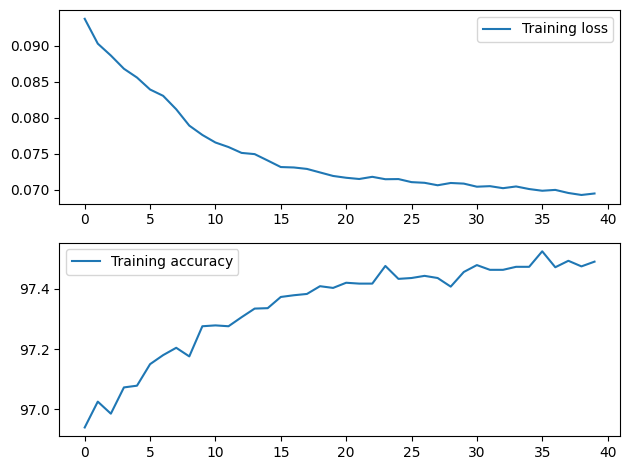

In [ ]:
import matplotlib.pyplot as plt
# Create figure and subplots
fig, axs = plt.subplots(2)

# Plot Loss
axs[0].plot(T_loss, label='Training loss')
#axs[0].plot(V_loss, label='Validation loss')
#axs[0].set_title(f'Plot for layers (2,4,1 nodes)')   #####Change Change Change
axs[0].legend()

# Plot Accuracy
axs[1].plot(T_accuracy, label='Training accuracy')
#axs[1].plot(V_accuracy, label='Validation accuracy')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('/content/drive/MyDrive/Model/FullyTrained_relu_2_8_4_2_1_NERHVG.png',dpi=1000)

In [ ]:
with open('/content/drive/MyDrive/Model/TrainingLoss_2_8_4_2_1_NERHVG001', 'wb') as f: #Saving Dataset
    pickle.dump(T_loss, f)
with open('/content/drive/MyDrive/Model/TrainingAccuracy_2_8_4_2_1_NERHVG001', 'wb') as f: #Saving Dataset
    pickle.dump(T_accuracy, f)

# **Load Selected Model and Train with HVG Training Data**

In [ ]:
# Initialize your model, loss function, and optimizer
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/model_leaky_relu_2_8_4_2_1_HVG"))

<All keys matched successfully>

In [ ]:
#uploading Dataset
import pickle
with open('/content/drive/MyDrive/Training_Graph/Training_HVG_1_2_3_7_8_9.pkl', 'rb') as f:
    train_data=pickle.load(f)
from torch_geometric.data import Data, DataLoader
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
T_loss=[]
T_accuracy=[]

# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data.x, data.y
        #print('label is', labels, len(labels))
        optimizer.zero_grad()
        labels = labels.view(-1, 1)
        outputs = model(inputs, data.edge_index, data.batch)
        #print('output is', outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Calculate training accuracy
        predicted = outputs.round()
        correct_train += predicted.eq(labels.view_as(predicted)).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    T_loss.append(train_loss)
    T_accuracy.append(train_accuracy)


    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/40], Training Loss: 0.0564, Training Accuracy: 98.11%
Epoch [2/40], Training Loss: 0.0461, Training Accuracy: 98.56%
Epoch [3/40], Training Loss: 0.0411, Training Accuracy: 98.72%
Epoch [4/40], Training Loss: 0.0373, Training Accuracy: 98.83%
Epoch [5/40], Training Loss: 0.0357, Training Accuracy: 98.87%
Epoch [6/40], Training Loss: 0.0345, Training Accuracy: 98.91%
Epoch [7/40], Training Loss: 0.0338, Training Accuracy: 98.93%
Epoch [8/40], Training Loss: 0.0330, Training Accuracy: 98.93%
Epoch [9/40], Training Loss: 0.0328, Training Accuracy: 98.97%
Epoch [10/40], Training Loss: 0.0325, Training Accuracy: 98.98%
Epoch [11/40], Training Loss: 0.0320, Training Accuracy: 98.99%
Epoch [12/40], Training Loss: 0.0320, Training Accuracy: 99.01%
Epoch [13/40], Training Loss: 0.0319, Training Accuracy: 99.02%
Epoch [14/40], Training Loss: 0.0317, Training Accuracy: 99.02%
Epoch [15/40], Training Loss: 0.0317, Training Accuracy: 99.00%
Epoch [16/40], Training Loss: 0.0313, Training Ac

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG")

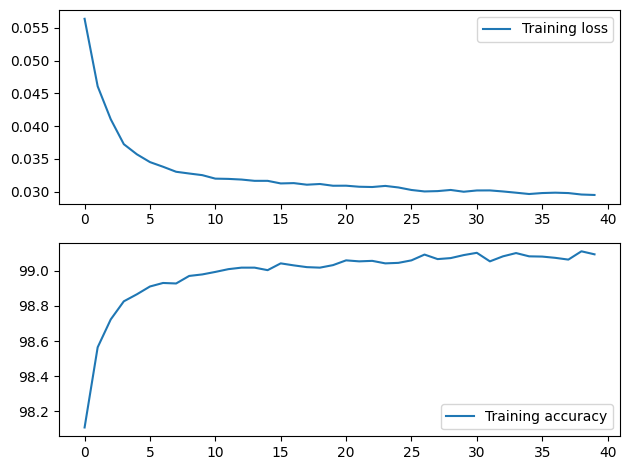

In [ ]:
import matplotlib.pyplot as plt
# Create figure and subplots
fig, axs = plt.subplots(2)

# Plot Loss
axs[0].plot(T_loss, label='Training loss')
#axs[0].plot(V_loss, label='Validation loss')
#axs[0].set_title(f'Plot for layers (2,4,1 nodes)')   #####Change Change Change
axs[0].legend()

# Plot Accuracy
axs[1].plot(T_accuracy, label='Training accuracy')
#axs[1].plot(V_accuracy, label='Validation accuracy')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('/content/drive/MyDrive/Model/FullyTrained_relu_2_8_4_2_1_HVG.png',dpi=1000)

In [ ]:
with open('/content/drive/MyDrive/Model/TrainingLoss_2_8_4_2_1_HVG001', 'wb') as f: #Saving Dataset
    pickle.dump(T_loss, f)
with open('/content/drive/MyDrive/Model/TrainingAccuracy_2_8_4_2_1_HVG001', 'wb') as f: #Saving Dataset
    pickle.dump(T_accuracy, f)

# **Testing Unseen Data**

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_model(model, loader,th):
    model.eval()
    y_true = []
    y_pred = []

    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            y_true.extend(data.y.tolist())

            #y_pred.extend((out > 0.5).squeeze().tolist())
            #y_pred.extend(out.round())


            # Convert probabilities to binary predictions
            y_pred.extend((out > th).to(torch.int).tolist())

    # print("yTrue: ", y_true)
    # print("YPred: ", y_pred)
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate sensitivity
    sensitivity = TP / (TP + FN)

    # Calculate specificity
    specificity = TN / (TN + FP)

    # Calculate F1_score
    F1_score = TP/ (TP + (FP + FN)/2)


    return {
        "confusion_matrix": conf_matrix,
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "F1_score": F1_score
    }

# # Example usage:
# results = evaluate_model(model, DataLoader(test_data, batch_size=batch_size))
# print("Confusion Matrix:")
# print(results["confusion_matrix"])
# print("Accuracy:", results["accuracy"])
# print("Sensitivity:", results["sensitivity"])
# print("Specificity:", results["specificity"])

PTT Data Test on NERHVGCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/PTT/NERHVG_PTT.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.72)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[3334,    0],
        [   0, 2755]]),
 'accuracy': 1.0,
 'sensitivity': 1.0,
 'specificity': 1.0,
 'F1_score': 1.0}

PTT Data Test on HVGCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/PTT/HVG_PTT.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[3334,    0],
        [   0, 2755]]),
 'accuracy': 1.0,
 'sensitivity': 1.0,
 'specificity': 1.0,
 'F1_score': 1.0}

**Queensland Data Test on NERHVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Queensland/NERHVG_Queens.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.72)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[4348,   84],
        [   7, 1882]]),
 'accuracy': 0.9856035437430787,
 'sensitivity': 0.9962943356273161,
 'specificity': 0.9810469314079422,
 'F1_score': 0.9763942931258106}

**Queensland Data Test on HVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Queensland/HVG_Queens.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[4432,    0],
        [   0, 1889]]),
 'accuracy': 1.0,
 'sensitivity': 1.0,
 'specificity': 1.0,
 'F1_score': 1.0}

**UCI Data Test on NERHVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/UCI/NERHVG_UCI.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.72)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[7740,  259],
        [ 330, 5297]]),
 'accuracy': 0.9567738147658887,
 'sensitivity': 0.9413541851786031,
 'specificity': 0.9676209526190774,
 'F1_score': 0.9473307699186265}

**UCI Data Test on HVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/UCI/HVG_UCI.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[7031,  968],
        [  34, 5593]]),
 'accuracy': 0.9264641127256715,
 'sensitivity': 0.9939577039274925,
 'specificity': 0.8789848731091386,
 'F1_score': 0.9177879881851001}

**Pulse Data Test NERHVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Pulse/NERHVG_Pulse.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.72)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[8000,    1],
        [ 112, 1808]]),
 'accuracy': 0.9886100191512952,
 'sensitivity': 0.9416666666666667,
 'specificity': 0.9998750156230471,
 'F1_score': 0.9696969696969697}

**Pulse Data Test on HVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Pulse/HVG_Pulse.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[8000,    1],
        [   1, 1919]]),
 'accuracy': 0.999798407418607,
 'sensitivity': 0.9994791666666667,
 'specificity': 0.9998750156230471,
 'F1_score': 0.9994791666666667}

**Vital Data Test on NERHVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Vital/NERHVG_Vital.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.72)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[6859,   79],
        [  57, 1801]]),
 'accuracy': 0.9845384265575261,
 'sensitivity': 0.9693218514531755,
 'specificity': 0.9886134332660709,
 'F1_score': 0.9636169074371321}

**Vital Data Test on HVGCN**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))

# Load test data
with open('/content/drive/MyDrive/Test data/Vital/HVG_Vital.pkl', 'rb') as f:
    test_data = pickle.load(f)
batch_size=8
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
evaluate_model(model, test_loader,0.8)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[6778,  160],
        [   4, 1854]]),
 'accuracy': 0.9813551614370168,
 'sensitivity': 0.9978471474703983,
 'specificity': 0.9769385990198904,
 'F1_score': 0.9576446280991735}

**Overall test on NERHVGCN_2_8_4_2_1** Except PTT

In [ ]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

with open('/content/drive/MyDrive/Test data/Vital/NERHVG_Vital.pkl', 'rb') as f:
    test_data1 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Pulse/NERHVG_Pulse.pkl', 'rb') as f:
    test_data2 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/UCI/NERHVG_UCI.pkl', 'rb') as f:
    test_data3 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Queensland/NERHVG_Queens.pkl', 'rb') as f:
    test_data4 = pickle.load(f)


batch_size=8
test_data=test_data1+test_data2+test_data3+test_data4
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

t=time.time()
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))
print(evaluate_model(model, test_loader,0.72))
t1=time.time()
T= (t1-t)/len(test_data)
print('Average time:', T*1000,'ms')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[26947,   423],
       [  506, 10788]]), 'accuracy': 0.9759724808607491, 'sensitivity': 0.9551974499734373, 'specificity': 0.9845451223967848, 'F1_score': 0.9587202843812486}
Average time: 1.9655479127862994 ms


**Overall Test on HVGCN** Except PTT

In [ ]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

with open('/content/drive/MyDrive/Test data/Vital/HVG_Vital.pkl', 'rb') as f:
    test_data1 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Pulse/HVG_Pulse.pkl', 'rb') as f:
    test_data2 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/UCI/HVG_UCI.pkl', 'rb') as f:
    test_data3 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Queensland/HVG_Queens.pkl', 'rb') as f:
    test_data4 = pickle.load(f)


batch_size=8
test_data=test_data1+test_data2+test_data3+test_data4
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

t=time.time()
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))
print(evaluate_model(model, test_loader,0.8))
t1=time.time()
T= (t1-t)/len(test_data)
print('Average time:', T*1000,'ms')

{'confusion_matrix': array([[26241,  1129],
       [   39, 11255]]), 'accuracy': 0.9697910200703497, 'sensitivity': 0.9965468390295732, 'specificity': 0.9587504567044209, 'F1_score': 0.9506715094180251}
Average time: 2.174820246075883 ms


**Overall test on NERHVGCN_2_8_4_2_1**

In [ ]:
import time
import torch                                                          #ALLLL
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

with open('/content/drive/MyDrive/Test data/Vital/NERHVG_Vital.pkl', 'rb') as f:
    test_data1 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Pulse/NERHVG_Pulse.pkl', 'rb') as f:
    test_data2 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/UCI/NERHVG_UCI.pkl', 'rb') as f:
    test_data3 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Queensland/NERHVG_Queens.pkl', 'rb') as f:
    test_data4 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/PTT/NERHVG_PTT.pkl', 'rb') as f:
    test_data5 = pickle.load(f)


batch_size=8
test_data=test_data1+test_data2+test_data3+test_data4 + test_data5
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

t=time.time()
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_NERHVG"))
print(evaluate_model(model, test_loader,0.72))
t1=time.time()
T= (t1-t)/len(test_data)
print('Average time:', T*1000,'ms')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[30281,   423],
       [  506, 13543]]), 'accuracy': 0.9792416150872567, 'sensitivity': 0.9639832016513631, 'specificity': 0.9862232933819698, 'F1_score': 0.9668391932893093}
Average time: 2.183814902541395 ms


## Threshold Testing

In [ ]:
import time
import torch                                                          #ALLLL
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle
import random
with open('/content/drive/MyDrive/Test data/Vital/HVG_Vital.pkl', 'rb') as f:
    test_data1 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Pulse/HVG_Pulse.pkl', 'rb') as f:
    test_data2 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/UCI/HVG_UCI.pkl', 'rb') as f:
    test_data3 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Queensland/HVG_Queens.pkl', 'rb') as f:
    test_data4 = pickle.load(f)
# with open('/content/drive/MyDrive/Test data/PTT/NERHVG_PTT.pkl', 'rb') as f:
#     test_data5 = pickle.load(f)



In [ ]:
batch_size=8
test_data=test_data1+test_data2+test_data3+test_data4
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
t=time.time()
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))
print(evaluate_model(model, test_loader,0.75))
t1=time.time()
T= (t1-t)/len(test_data)
print('Average time:', T*1000,'ms')

{'confusion_matrix': array([[26153,  1217],
       [   22, 11272]]), 'accuracy': 0.9679546865301055, 'sensitivity': 0.9980520630423234, 'specificity': 0.9555352575812934, 'F1_score': 0.947903965017029}
Average time: 2.0918375570631507 ms


**Overall test on HVGCN_2_8_4_2_1**

In [ ]:
import time
import torch                                                                     #ALLLL
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

with open('/content/drive/MyDrive/Test data/Vital/HVG_Vital.pkl', 'rb') as f:
    test_data1 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Pulse/HVG_Pulse.pkl', 'rb') as f:
    test_data2 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/UCI/HVG_UCI.pkl', 'rb') as f:
    test_data3 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/Queensland/HVG_Queens.pkl', 'rb') as f:
    test_data4 = pickle.load(f)
with open('/content/drive/MyDrive/Test data/PTT/HVG_PTT.pkl', 'rb') as f:
    test_data5 = pickle.load(f)


batch_size=8
test_data=test_data1+test_data2+test_data3+test_data4 +test_data5
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

t=time.time()
model=GCNClassifier(in_channels=2, hidden_channels=8, out_channels=1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Model/Trained_Lrelu_2_8_4_2_1_HVG"))
print(evaluate_model(model, test_loader,0.8))
t1=time.time()
T= (t1-t)/len(test_data)
print('Average time:', T*1000,'ms')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'confusion_matrix': array([[29575,  1129],
       [   39, 14010]]), 'accuracy': 0.9739011909816102, 'sensitivity': 0.9972240017083066, 'specificity': 0.9632295466388744, 'F1_score': 0.9599835548855694}
Average time: 1.808147245238374 ms


In [ ]:
len(test_data)

44753

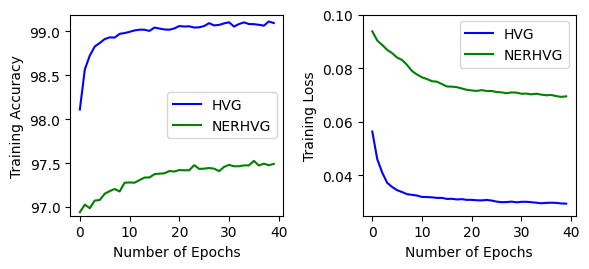

In [ ]:
import matplotlib.pyplot as plt
import pickle
with open('/content/drive/MyDrive/Model/TrainingLoss_2_8_4_2_1_NERHVG001', 'rb') as f: #Saving Dataset
    NERHVG_Loss=pickle.load(f)
with open('/content/drive/MyDrive/Model/TrainingLoss_2_8_4_2_1_HVG001', 'rb') as f: #Saving Dataset
    HVG_Loss=pickle.load(f)
with open('/content/drive/MyDrive/Model/TrainingAccuracy_2_8_4_2_1_NERHVG001', 'rb') as f: #Saving Dataset
    NERHVG_Acc=pickle.load(f)
with open('/content/drive/MyDrive/Model/TrainingAccuracy_2_8_4_2_1_HVG001', 'rb') as f: #Saving Dataset
    HVG_Acc=pickle.load(f)

# Assuming you have lists HVG_Acc, NERHVG_Acc, HVG_Loss, and NERHVG_Loss defined somewhere

# Create subplots with 1 row and 2 columns, and adjust the figure size
fig, axs = plt.subplots(1,2, figsize=(6, 2.8))  # Adjust the figure size as needed

# Plot A and B in the first subplot
axs[0].plot(HVG_Acc, label='HVG', color='blue')
axs[0].plot(NERHVG_Acc, label='NERHVG', color='green')
axs[0].set_xlabel('Number of Epochs', color='black')
axs[0].set_ylabel('Training Accuracy', color='black')
axs[0].legend()
axs[0].set_ylim([96.9, 99.19])

# Plot C and D in the second subplot
axs[1].plot(HVG_Loss, label='HVG', color='blue')
axs[1].plot(NERHVG_Loss, label='NERHVG', color='green')
axs[1].set_xlabel('Number of Epochs', color='black')
axs[1].set_ylabel('Training Loss', color='black')
axs[1].legend()
axs[1].set_ylim([0.025, 0.10])

# Save the figure
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Model/plots.png')

# Show the plots
plt.show()
